<a href="https://colab.research.google.com/github/xunzxe/first-repository/blob/master/Exploration_quest/Quest04/GAN%EC%9C%BC%EB%A1%9C%20%EC%84%B8%EC%83%81%EC%97%90%20%EC%97%86%EB%8D%98%20%EC%83%88%EB%A1%9C%EC%9A%B4%20%ED%8C%A8%EC%85%98%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 전처리하기
---

In [2]:
!pip list | grep -E 'imageio|Pillow'

imageio                          2.34.2
imageio-ffmpeg                   0.5.1
Pillow                           9.4.0


In [3]:
!pip install imageio
!pip install Pillow

In [4]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 작업 환경을 구축할 폴더 경로 지정
base_dir = '/content/drive/My\ Drive/aiffel/dcgan_newimage/fashion'

# 디렉토리 생성
!mkdir -p {base_dir}/generated_samples
!mkdir -p {base_dir}/training_checkpoints
!mkdir -p {base_dir}/training_history

In [6]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.17.0


In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0


In [9]:
train_x.shape

(60000, 28, 28)

In [10]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

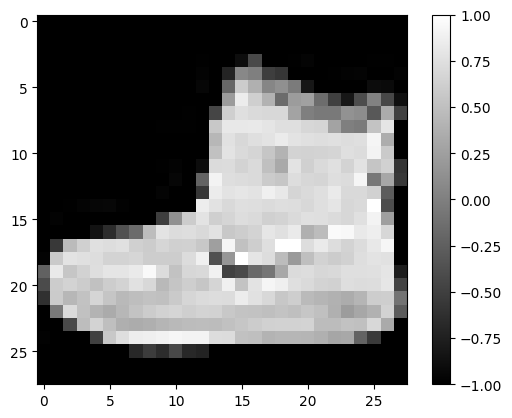

In [11]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

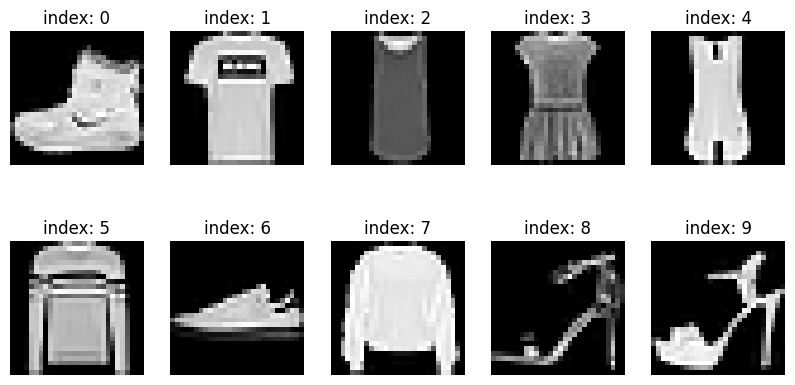

In [12]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

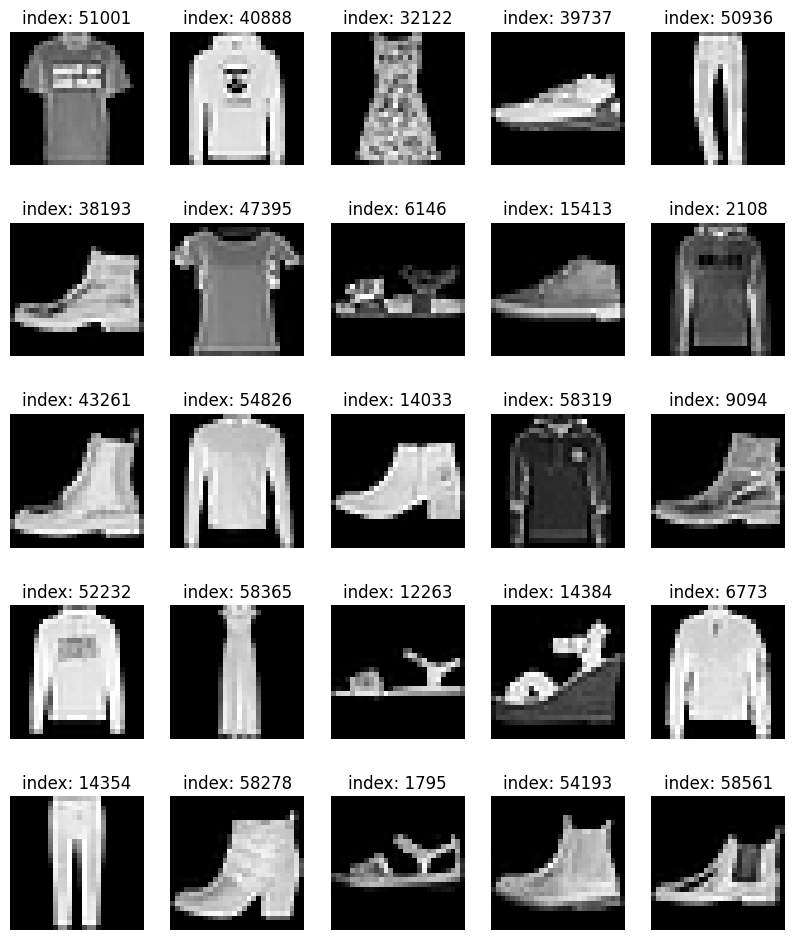

In [13]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i + 1)  # 5x5 배열로 서브플롯 설정
    random_index = np.random.randint(0, len(train_x))  # 랜덤 인덱스 추출
    plt.imshow(train_x[random_index], cmap='gray')  # 해당 인덱스의 이미지 출력
    plt.title(f'index: {random_index}')
    plt.axis('off')  # 축을 표시하지 않음

plt.show()

In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 모델 설계하기 : GAN
---

## (1) 생성자 설계하기
---

In [16]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [17]:
generator = make_generator_model()

generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [18]:
noise = tf.random.normal([1, 100])

In [19]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

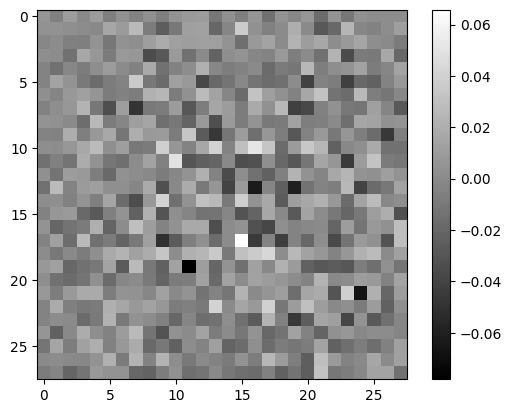

In [20]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## (2) 판별자 설계하기
---

In [21]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [22]:
discriminator = make_discriminator_model()

discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00173863]], dtype=float32)>

## (3) 손실함수 설계하기
---
- 교차 엔트로피
  - 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
  - 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

  - fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
  - real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # rom_logits를 True로 설정해 주어야 0~1 사이의 값 반환

In [25]:
# tf.ones_like()와 tf.zeros_like() 함수 활용
# 이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
# 판별자의 손실함수 구현
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)

    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)

    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss

    return total_loss

In [27]:
# 판별자의 정확도 구현
# real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## (4) 최적화 함수 설계하기
---
- Adam 최적화 기법

In [28]:
# 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 3. 훈련 설계하기
---

## (1) train_step 설계하기
---
- 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [30]:
# @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)  # [[YOUR CODE]]

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)  # [[YOUR CODE]]

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # [[YOUR CODE]]

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # [[YOUR CODE]]

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


In [39]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # 저장할 디렉토리 경로 설정 및 생성
    save_dir = os.path.join(base_dir, 'generated_samples')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 이미지 파일 저장
    plt.savefig(os.path.join(save_dir, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)))

    plt.show()

In [40]:
# train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리 경로 설정 및 생성
    save_dir = os.path.join(base_dir, 'training_history')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 그래프를 이미지 파일로 저장
    plt.savefig(os.path.join(save_dir, 'train_history_{:04d}.png'.format(epoch)))
    plt.show()

## (2) checkpoint 설계하기
---
- tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리 가능

In [45]:
# 구글 드라이브 마운트 경로와 프로젝트 경로를 조합하여 경로 설정
checkpoint_dir = os.path.join(base_dir, 'training_checkpoints')

# 디렉토리가 존재하지 않으면 생성
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 4. 모델 학습하기
---

In [46]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [47]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

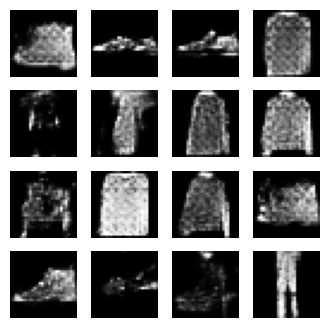

Time for training : 880 sec


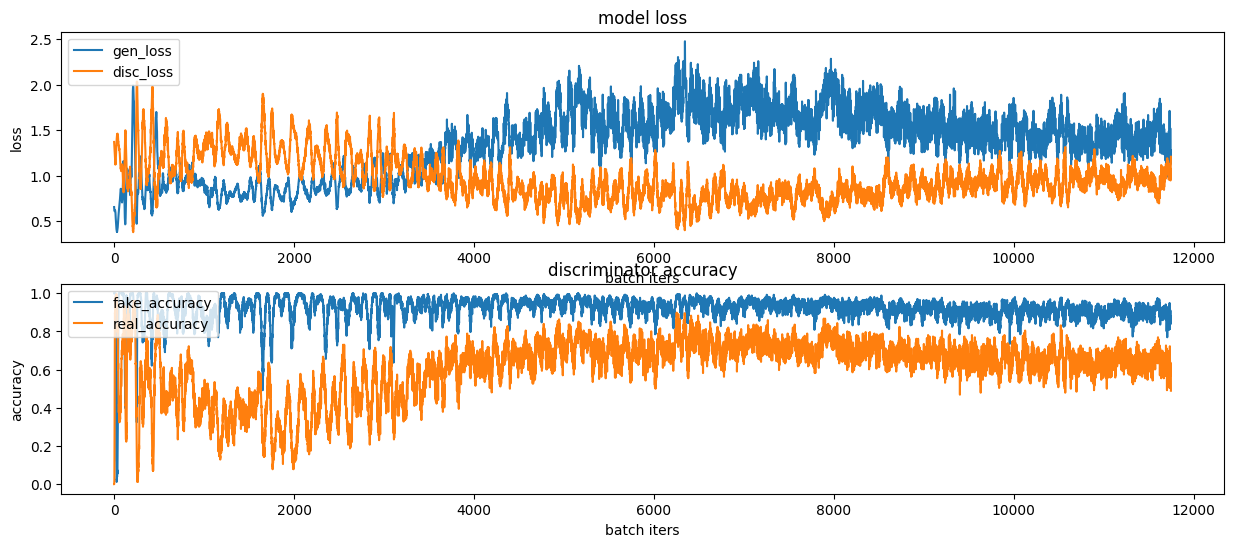

CPU times: user 6min 54s, sys: 57.5 s, total: 7min 52s
Wall time: 14min 42s


In [48]:
%%time
train(train_dataset, EPOCHS, save_every)

In [50]:
import os
import imageio.v2 as imageio  # imageio v2를 사용하여 경고를 피합니다.
import glob

# 애니메이션 파일 경로 설정
anim_file = os.path.join(base_dir, 'fashion_mnist_dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    # 생성된 샘플 이미지 파일 경로 설정
    filenames = glob.glob(os.path.join(base_dir, 'generated_samples', 'sample*.png'))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# 애니메이션 파일이 올바르게 생성되었는지 확인
!ls -l "{anim_file}"

-rw------- 1 root root 635722 Aug 20 23:49 '/content/drive/My Drive/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'
